In [1]:
import pandas as pd
import urllib
from urllib.request import urlopen
from bs4 import BeautifulSoup
import math

In [2]:
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.tools.plotting import autocorrelation_plot
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
import operator

In [3]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

In [4]:
%matplotlib inline

In [5]:
def readFile(filename):
    
    print("=====WV: Total Personal Income File=====")
    dateparse = lambda dates: pd.datetime.strptime(dates, '%Y')
    df_1 = pd.read_csv(filename, header=0,parse_dates=[0],index_col=0,date_parser=dateparse)
    print("File read into dataframe.")
    print(df_1.shape)
    df_1 = df_1.sort()
    return df_1

In [6]:
df_WV = readFile("WV_TotalPersonalIncome.csv")

=====WV: Total Personal Income File=====
File read into dataframe.
(39, 1)


In [7]:
df_WV.index

DatetimeIndex(['1977-01-01', '1978-01-01', '1979-01-01', '1980-01-01',
               '1981-01-01', '1982-01-01', '1983-01-01', '1984-01-01',
               '1985-01-01', '1986-01-01', '1987-01-01', '1988-01-01',
               '1989-01-01', '1990-01-01', '1991-01-01', '1992-01-01',
               '1993-01-01', '1994-01-01', '1995-01-01', '1996-01-01',
               '1997-01-01', '1998-01-01', '1999-01-01', '2000-01-01',
               '2001-01-01', '2002-01-01', '2003-01-01', '2004-01-01',
               '2005-01-01', '2006-01-01', '2007-01-01', '2008-01-01',
               '2009-01-01', '2010-01-01', '2011-01-01', '2012-01-01',
               '2013-01-01', '2014-01-01', '2015-01-01'],
              dtype='datetime64[ns]', freq=None)

In [8]:
df_WV.head()

,WV_Total Personal Income
1977-01-01,11394.0
1978-01-01,12680.9
1979-01-01,14145.7
1980-01-01,15557.9
1981-01-01,16961.6


In [9]:
df_WV.rename(columns={'WV_Total Personal Income': 'WV_TotalPersonalIncome'}, inplace=True)

In [10]:
df_WV.WV_TotalPersonalIncome.describe()

count       39.000000
mean     36795.858974
std      17411.552017
min      11394.000000
25%      21435.800000
50%      34072.100000
75%      49876.500000
max      68328.600000
Name: WV_TotalPersonalIncome, dtype: float64

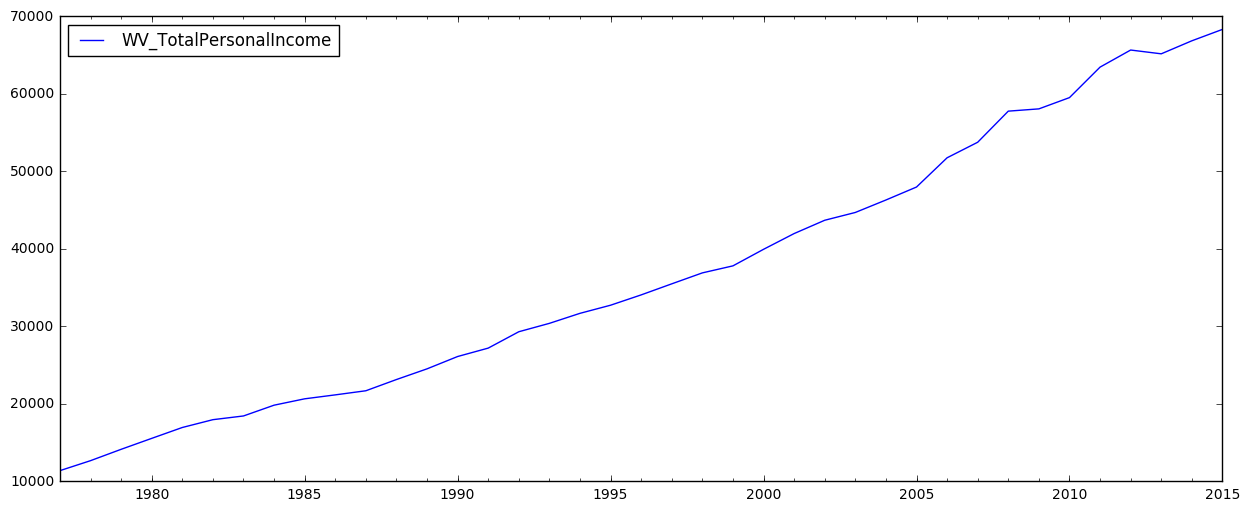

In [11]:
df_WV.plot(figsize=(15,6))
plt.show()
#fig.savefig('DC_TotalPersonalIncome.png', dpi=150)

There is an overall increasing trend in the data.

In [12]:
#Further Decompose time-series into trend, seasionality and noise
def decompose(df):
    decomposition = sm.tsa.seasonal_decompose(df, model='additive')
    fig = decomposition.plot()
    plt.show()
    #fig.savefig('Seasonal_Decompose.png', dpi=150)

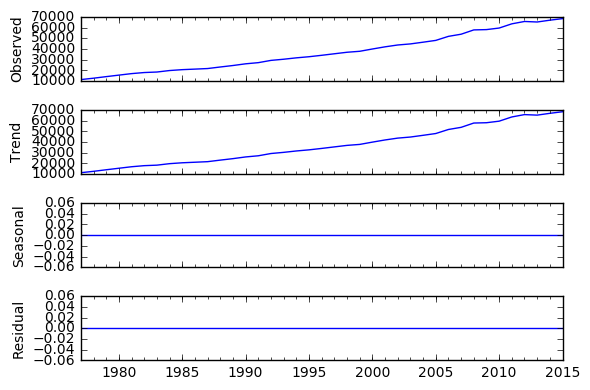

In [13]:
decompose(df_WV)

# Stationarity

We are taking two techniques to check if the dataset is stationary or not.
First, check the mean and variance.
Second, Dickey-Fuller test.

Plotting Rolling Statistics: We can plot the moving average or moving variance and see if it varies with time. By moving average/variance I mean that at any instant ‘t’, we’ll take the average/variance of the last year, i.e. last 12 months. But again this is more of a visual technique.

Dickey-Fuller Test: This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the TS is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels.
If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary. Refer this article for details.

In [14]:
#Split the dataset and calculate the mean and variance for each group.
def meanVarianceCheck(df):
    X = df.values
    split = len(X) / 2
    X1, X2 = X[0:split], X[split:]
    mean1, mean2 = X1.mean(), X2.mean()
    var1, var2 = X1.var(), X2.var()
    return ('mean1=%f, mean2=%f' % (mean1, mean2), 'variance1=%f, variance2=%f' % (var1, var2))

In [15]:
meanVarianceCheck(df_WV)

('mean1=21878.189474, mean2=50967.645000',
 'variance1=39415022.516731, variance2=126314262.215475')

In [16]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=5)
    rolstd = pd.rolling_std(timeseries, window=5)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

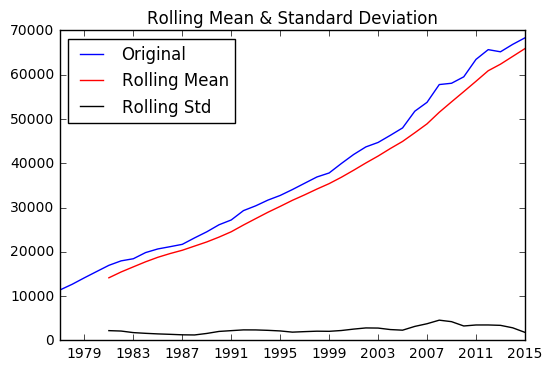

Results of Dickey-Fuller Test:
Test Statistic                  1.844308
p-value                         0.998433
#Lags Used                      0.000000
Number of Observations Used    38.000000
Critical Value (10%)           -2.609200
Critical Value (1%)            -3.615509
Critical Value (5%)            -2.941262
dtype: float64


In [17]:
test_stationarity(df_WV.WV_TotalPersonalIncome)

# Estimating & Eliminating Trend

In [18]:
#log transform
def logTransform(df):
    ts_log = np.log(df)
    plt.plot(ts_log)
    return ts_log

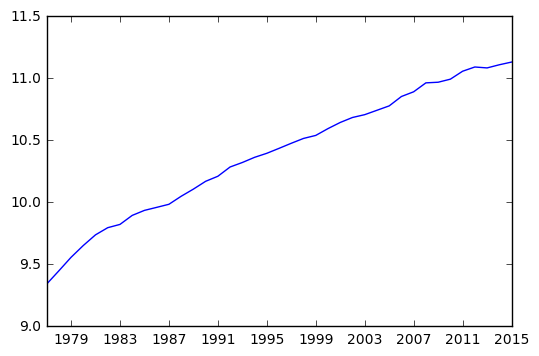

In [19]:
ts_log = logTransform(df_WV)

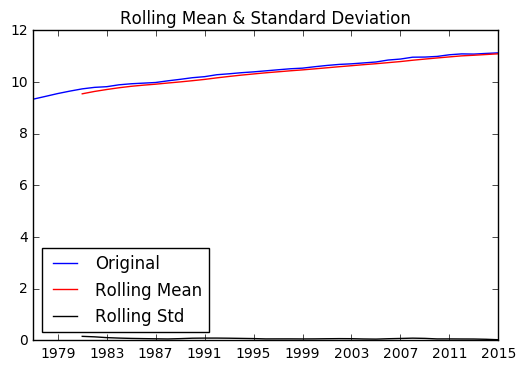

Results of Dickey-Fuller Test:
Test Statistic                 -4.643806
p-value                         0.000107
#Lags Used                      0.000000
Number of Observations Used    38.000000
Critical Value (10%)           -2.609200
Critical Value (1%)            -3.615509
Critical Value (5%)            -2.941262
dtype: float64


In [20]:
test_stationarity(ts_log.WV_TotalPersonalIncome)

In [21]:
def logFirstDifference(ts_log):
    ts_log_diff = ts_log - ts_log.shift()
    ts_log_diff.dropna(inplace=True)
    return ts_log_diff

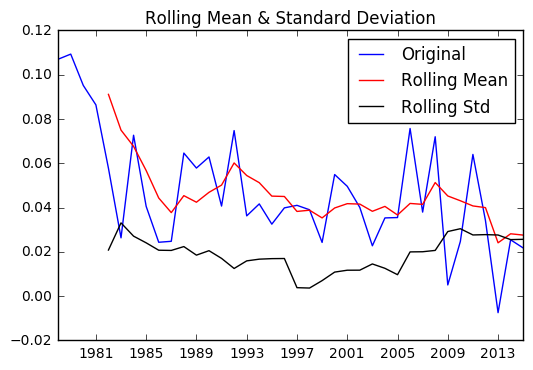

Results of Dickey-Fuller Test:
Test Statistic                 -4.161466
p-value                         0.000765
#Lags Used                      0.000000
Number of Observations Used    37.000000
Critical Value (10%)           -2.610400
Critical Value (1%)            -3.620918
Critical Value (5%)            -2.943539
dtype: float64


In [22]:
ts_log_diff = logFirstDifference(ts_log)
test_stationarity(ts_log_diff.WV_TotalPersonalIncome)

In [23]:
def firstDifference(df):
    ts_first_diff = df - df.shift()
    ts_first_diff.dropna(inplace=True)
    return ts_first_diff

In [24]:
ts_first_diff = firstDifference(df_WV)

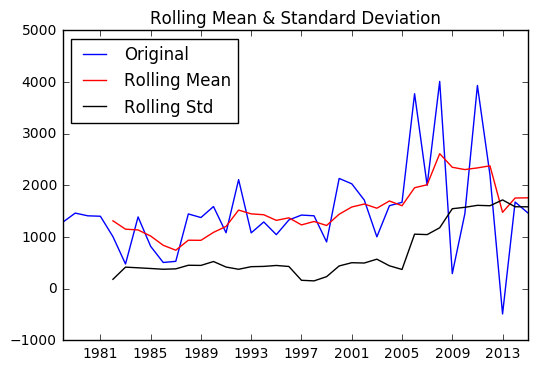

Results of Dickey-Fuller Test:
Test Statistic                 -5.570564
p-value                         0.000001
#Lags Used                      0.000000
Number of Observations Used    37.000000
Critical Value (10%)           -2.610400
Critical Value (1%)            -3.620918
Critical Value (5%)            -2.943539
dtype: float64


In [25]:
test_stationarity(ts_first_diff.WV_TotalPersonalIncome)

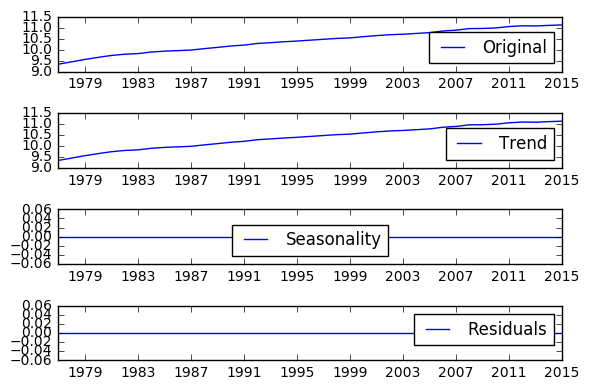

In [26]:
#Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

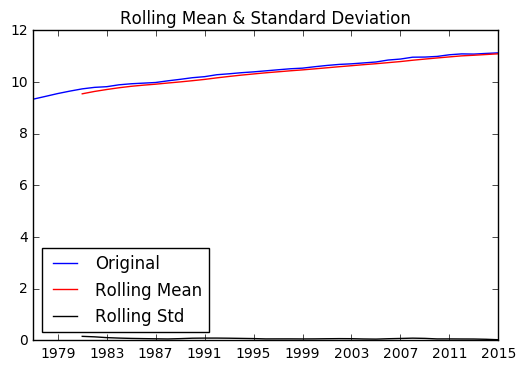

Results of Dickey-Fuller Test:
Test Statistic                 -4.643806
p-value                         0.000107
#Lags Used                      0.000000
Number of Observations Used    38.000000
Critical Value (10%)           -2.609200
Critical Value (1%)            -3.615509
Critical Value (5%)            -2.941262
dtype: float64


In [27]:
ts_log_decompose = trend
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose.WV_TotalPersonalIncome)

# Forecasting a Time Series

In [28]:
lag_acf = acf(ts_log, nlags=10)
lag_pacf = pacf(ts_log, nlags=10, method='ols')

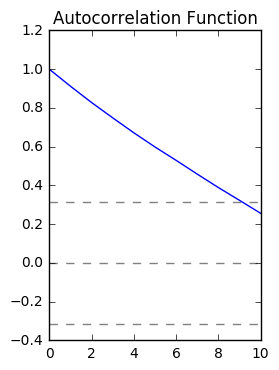

In [29]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

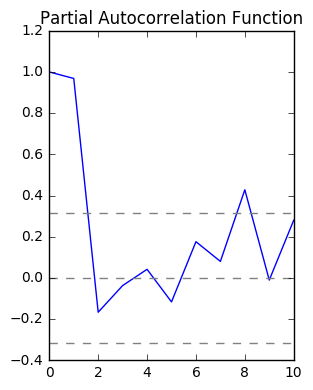

In [30]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [31]:
aic_metric = pd.DataFrame({'Modelname':[],'AIC':[]})
aic_dict = {} 

In [32]:
def cal_aic_metric(modelname,model):
    global aic_metric
    AIC = model.aic
    aic_dict[modelname] = AIC
    df_error = pd.DataFrame({'Modelname':[modelname],'AIC':[AIC]})
    aic_metric = pd.concat([aic_metric,df_error])
    return aic_metric

In [35]:
def AR_Model(ts):
    model = ARIMA(ts, order=(2, 0, 0))
    results_AR = model.fit(disp=0)
    cal_aic_metric('ARIMA(ts, order=(2, 0, 0))',results_AR)
    print('Lag: %s' % results_AR.k_ar)
    print('Coefficients: %s' % results_AR.params)
    print(results_AR.summary())
    plt.plot(ts)
    plt.plot(results_AR.fittedvalues, color='red')
    return results_AR

Lag: 2
Coefficients: const                           10.063081
ar.L1.WV_TotalPersonalIncome     1.885274
ar.L2.WV_TotalPersonalIncome    -0.888229
dtype: float64
                                ARMA Model Results                                
Dep. Variable:     WV_TotalPersonalIncome   No. Observations:                   39
Model:                         ARMA(2, 0)   Log Likelihood                  82.294
Method:                           css-mle   S.D. of innovations              0.026
Date:                    Thu, 27 Apr 2017   AIC                           -156.588
Time:                            19:09:19   BIC                           -149.934
Sample:                        01-01-1977   HQIC                          -154.201
                             - 01-01-2015                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------

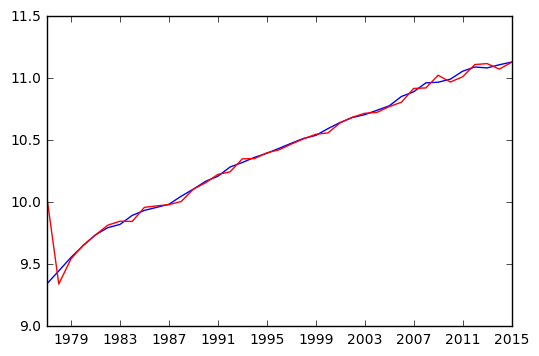

In [36]:
model_AR = AR_Model(ts_log)

In [37]:
def MA_Model(ts):
    model = ARIMA(ts_log, order=(0, 0, 5))  
    results_MA = model.fit(disp=0)
    cal_aic_metric('ARIMA(ts, order=(0, 0, 5))',results_MA)
    print('Lag: %s' % results_MA.k_ar)
    print('Coefficients: %s' % results_MA.params)
    print(results_MA.summary())
    plt.plot(ts)
    plt.plot(results_MA.fittedvalues, color='red')
    return results_MA

Lag: 0
Coefficients: const                           10.344967
ma.L1.WV_TotalPersonalIncome     2.418757
ma.L2.WV_TotalPersonalIncome     3.762931
ma.L3.WV_TotalPersonalIncome     3.760734
ma.L4.WV_TotalPersonalIncome     2.414572
ma.L5.WV_TotalPersonalIncome     0.998013
dtype: float64
                                ARMA Model Results                                
Dep. Variable:     WV_TotalPersonalIncome   No. Observations:                   39
Model:                         ARMA(0, 5)   Log Likelihood                  43.506
Method:                           css-mle   S.D. of innovations              0.064
Date:                    Thu, 27 Apr 2017   AIC                            -73.013
Time:                            19:09:46   BIC                            -61.368
Sample:                        01-01-1977   HQIC                           -68.834
                             - 01-01-2015                                         
                                   coef    std e

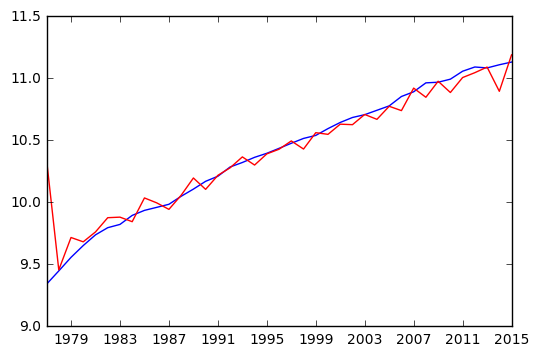

In [38]:
model_MA = MA_Model(ts_log)

In [41]:
def Combined_Model(ts):
    model = ARIMA(ts_log, order=(1, 0, 5))  
    results_ARIMA = model.fit(disp=0)
    cal_aic_metric('ARIMA(ts, order=(1, 0, 5))',results_ARIMA)
    print('Lag: %s' % results_ARIMA.k_ar)
    print('Coefficients: %s' % results_ARIMA.params)
    print(results_ARIMA.summary())
    plt.plot(ts)
    plt.plot(results_ARIMA.fittedvalues, color='red')
    return results_ARIMA

In [43]:
#model_Combined = Combined_Model(ts_log)

In [44]:
aic_metric

,AIC,Modelname
0,-156.588370,"ARIMA(ts, order=(2, 0, 0))"
0,-73.012519,"ARIMA(ts, order=(0, 0, 5))"


In [45]:
aic_dict

{'ARIMA(ts, order=(0, 0, 5))': -73.01251894600867,
 'ARIMA(ts, order=(2, 0, 0))': -156.58837012685117}

In [46]:
#### Calculate best model
best_model =  min(aic_dict.items(),key=operator.itemgetter(1))[0]
print('Best Model is ', best_model)

Best Model is  ARIMA(ts, order=(2, 0, 0))


In [47]:
#Forecast using Best Model
def forecast(model,numSteps):
    #model.forecast(steps=numSteps)
    output = model.forecast(steps=numSteps)[0]
    output.tolist()
    output = np.exp(output)
    print(output)
    return output    

In [49]:
output_forecast = forecast(model_AR,5)

[ 69443.26733917  70223.06778227  70693.6790495   70882.94611772
  70819.74097574]


In [58]:
#AR Model
#model = ARIMA(ts_log, order=(5, 1, 0))
#results_AR = model.fit(disp=0)  
#print(results_AR.summary())
#print('Lag: %s' % results_AR.k_ar)
#print('Coefficients: %s' % results_AR.params)
#plt.plot(ts_log_diff)
#plt.plot(results_AR.fittedvalues, color='red')
#print(results_AR.aic)
#plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))


#MA Model
#model = ARIMA(ts_log, order=(0, 1, 2))  
#results_MA = model.fit(disp=-1)  
#print('Lag: %s' % results_MA.k_ar)
#print('Coefficients: %s' % results_MA.params)
#print(results_MA.summary())
#plt.plot(ts_log_diff)
#plt.plot(results_MA.fittedvalues, color='red')
#plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))



#Combined Model
#model = ARIMA(ts_log, order=(5, 1,1))  
#results_ARIMA = model.fit(disp=-1)
#print('Lag: %s' % results_ARIMA.k_ar)
#print('Coefficients: %s' % results_ARIMA.params)
#print(results_ARIMA.summary())
#plt.plot(ts_log_diff)
#plt.plot(results_ARIMA.fittedvalues, color='red')

In [80]:
model = ARIMA(ts_log, order=(5, 1,1))  
results_ARIMA = model.fit(disp=-1)
print('Lag: %s' % results_ARIMA.k_ar)
print('Coefficients: %s' % results_ARIMA.params)
print(results_ARIMA.fittedvalues())


Lag: 5
Coefficients: const                             0.052186
ar.L1.D.WV_TotalPersonalIncome   -0.626817
ar.L2.D.WV_TotalPersonalIncome    0.557715
ar.L3.D.WV_TotalPersonalIncome    0.237420
ar.L4.D.WV_TotalPersonalIncome    0.273951
ar.L5.D.WV_TotalPersonalIncome    0.221161
ma.L1.D.WV_TotalPersonalIncome    1.000000
dtype: float64


TypeError: 'Series' object is not callable